## 01. Preliminary simulation of spectra for ~10 stars using Slitless-Spectroscopy

In [35]:
import astropy.io.fits as fits
from scipy import signal
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import cm
import numpy as np
import os

import matplotlib
%matplotlib inline
font = {'family' : 'arial',
        'weight' : 'normal',
        'size'   : 20}
matplotlib.rc('font', **font)

#### 1. Defining the input parameters

In [36]:
def defineSpectralType(HiRes=True, MedRes=False):
  """
  Function decides which spectra to use: High-Resolution or Mid-Resolution
  @HiRes :: boolean selects spectra with resolution 5*e5 in optical and NIR
  @MidRes :: boolean selects spectra with resolution 1*e5 in IR
  """
  spectral_types_arr = ['HiRes','MedRes']
  if HiRes:
    spectral_type = spectral_types_arr[0]
  else:
    spectral_type = spectral_types_arr[1]
  return spectral_type

In [37]:
# array containing the wavelength values for all the spectra
wave_filename = 'WAVE_PHOENIX-ACES-AGSS-COND-2011.fits'

# setting up the working directory path
current_dir = os.getcwd()
data_dir = os.path.join(current_dir, "Data")

#### Chosen spectral parameters

In [38]:
# [K] effective temperature
t_eff_arr = [12000, 11800, 10000, 8400, 7600, 6900, 5900, 5100, 4700, 3900]    

# log of [cm/s^2] log (surface gravity) 
log_g_arr = [6.00, 2.50, 3.00, 6.00, 3.50, 3.00, 3.00, 2.00, 1.50, 6.00]    

# [M/H] metallicity
Fe_H = 0.0      

# [a/M] alpha element enhancement
alpha = 0       

spectral_type = defineSpectralType(HiRes=True, MedRes=False)

# number of spectra
num_spectra = len(t_eff_arr)
# parameters considered :: [t_eff, log_g, Fe_H, alpha, spectral_types]
num_params = 5

# positions of the 10 stars considered
pos = [2, 5, 9, 20, 22, 21, 8, 10, 12, 15]

# wavelength range for k-band
k_upper, k_lower = 2.4e4, 2.1e4

Opening the file and printing out file info

In [39]:
def defineSpectralFilename(params):
  """
  Function to put together the filename based on the spectral parameters
  @params:: arr containing [t_eff, log_g, Fe_H, alpha, spectral_types]
  
  @Returns filename :: fits filename for the given parameters
  """
  if alpha == 0:
    # names the file based on the length of T_eff
    if len(str(params[0])) == 4:
      filename = 'lte0'+str(params[0])+'-'+str(params[1])+'0-'+str(params[2])+'.PHOENIX-ACES-AGSS-COND-2011-'+ params[4]+'.fits'
    else:
      filename = 'lte'+str(params[0])+'-'+str(params[1])+'0-'+str(params[2])+'.PHOENIX-ACES-AGSS-COND-2011-'+ params[4]+'.fits'
  
  # if alpha is not equal to 0
  else:
    if len(str(params[0])) == 4:
      filename = 'lte0'+str(params[0])+'-'+str(params[1])+'-'+str(params[2])+'.Alpha='+str(params[3])+'.PHOENIX-ACES-AGSS-COND-2011-'+ params[4]+'.fits'
    else:
      filename = 'lte'+str(params[0])+'-'+str(params[1])+'-'+str(params[2])+'.Alpha='+str(params[3])+'.PHOENIX-ACES-AGSS-COND-2011-'+ params[4]+'.fits'
  return filename

def openFile(filename):
  "Function to open the fits file"
  hdu_list = fits.open(filename)
  return hdu_list

def extractWavelen(data_dir, wave_filename):
  "Function finds the length of the wavelength array"
  # open wavelength file and extract data
  wave_array = os.path.join(data_dir, wave_filename)
  hdu_wave = openFile(wave_array)
  wave_len = hdu_wave[0].data
  return wave_len, len(wave_len)

def readFile(data_dir, wave_filename, params):
  """
  Function to define the filename, open the file, and print out some basic info
  Inputs:
  @data_dir :: directory that stores the fits files
  @wave_arr :: wavelength array for all the spectra
  @params :: arr containing [t_eff, log_g, Fe_H, alpha, spectral_types]
  """
  # open wavelength file and extract data
  wave_len, _ = extractWavelen(data_dir, wave_filename)
  
  # define the spectral file name 
  spectral_file_name = defineSpectralFilename(params)
  filename = os.path.join(data_dir, spectral_file_name)
  
  # open the file and extract flux
  hdu_list = openFile(filename)
  flux = hdu_list[0].data
  return wave_len, flux

def setLabel(ax, xlabel, ylabel, title, xlim, ylim, legend=True):
    """
    Function defining plot properties
    @param ax :: axes to be held
    @param xlabel, ylabel :: labels of the x-y axis
    @param title :: title of the plot
    @param xlim, ylim :: x-y limits for the axis
    """
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    if legend:
      ax.legend(loc=(1.04,0))
    ax.grid(True)
    ax.set_title(title, fontsize=18)
    return
  
def labelSpectra(params):
  print(params[0])
  "Function labels the spectra based on the parameters"
  spectral_params = (str(params[0]), str(params[1]))
  label = r'$T_e =%s, \log g=%s$'
  return label%spectral_params

The following code blocks puts together the fluxes and wavelegnths for all the chosen spectra into a 2D array.

In [40]:
_, len_wavelen = extractWavelen(data_dir, wave_filename)
wave_len_arr2D, flux_arr2D = np.empty((0, len_wavelen)), np.empty((0, len_wavelen))
params_arr2D = np.empty((0, num_params)) 

for i in range(num_spectra):
  # choose the t_eff and log_g
  t_eff, log_g = t_eff_arr[i], log_g_arr[i]
  params = [t_eff, log_g, Fe_H, alpha, spectral_type]
  
  # read out the wavelength and flux for given set of parameters
  wave_len, flux = readFile(data_dir, wave_filename, params)
  
  # add the wavelength and flux values to the 2D arrays
  wave_len_arr2D = np.append(wave_len_arr2D, [wave_len], axis=0)
  flux_arr2D = np.append(flux_arr2D, [flux], axis=0)
  params_arr2D = np.append(params_arr2D, [params], axis=0)

#### 2. Plot the spectra

12000
11800
10000
8400
7600
6900
5900
5100
4700
3900


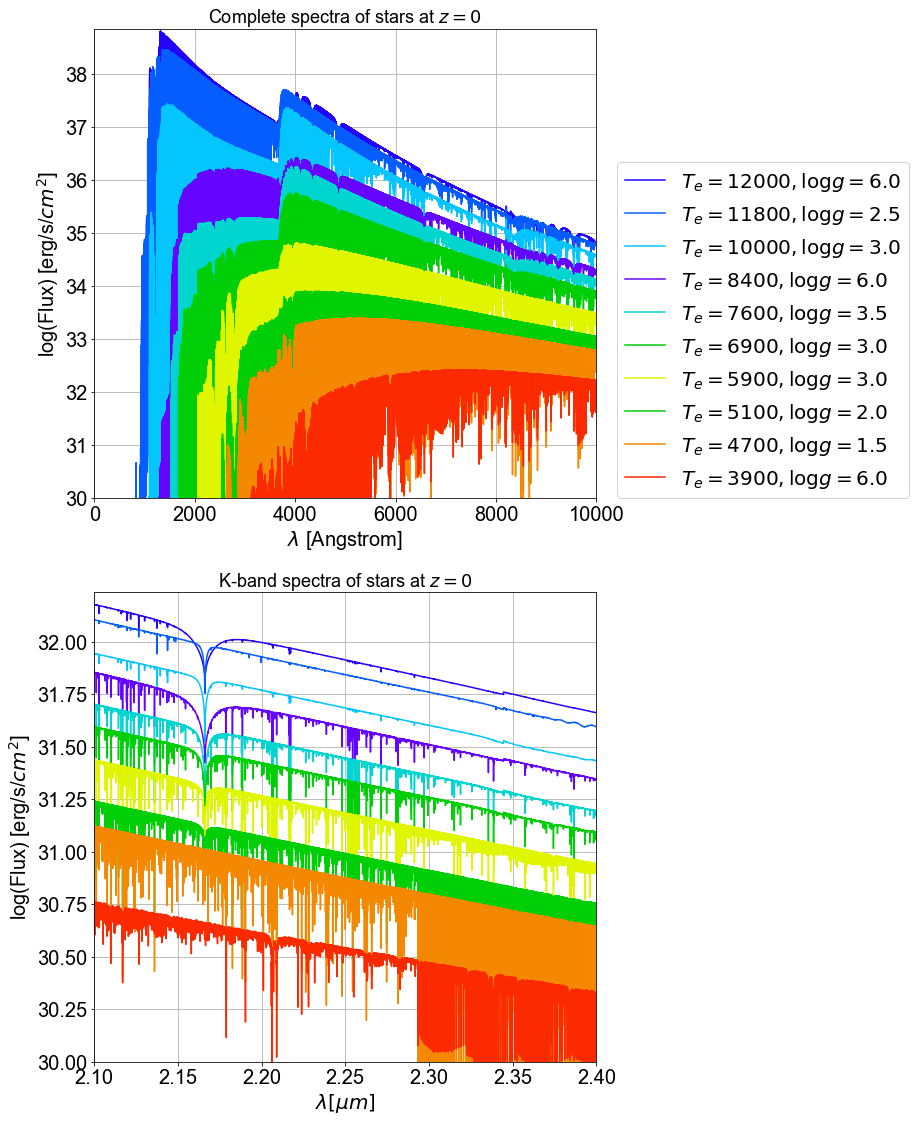

In [41]:
fig,ax = plt.subplots(2,1,figsize=(9,19))
colors = ['#2403fc', '#055dff', '#05c5ff', '#6505ff', '#02d4d0', '#00cf07', '#e0f500', '#00cf07', '#f58802', '#fc2a00']

for i in range(num_spectra):
  # complete spectra
  ax[0].plot(wave_len_arr2D[i], np.log(flux_arr2D[i]), color=colors[i], label=labelSpectra(params_arr2D[i]))
  setLabel(ax[0], r'$\lambda$ [Angstrom]', r'log(Flux) [erg/s/$cm^2$]', r'Complete spectra of stars at $z=0$', [0, 1e4], [30, np.log(7.5e16)], legend=True)

  # k-band spectra (flux is log)
  ax[1].plot(wave_len_arr2D[i]/10000, np.log(flux_arr2D[i]), color=colors[i])
  setLabel(ax[1], r'$\lambda [\mu m]$', r'log(Flux) [erg/s/$cm^2$]', r'K-band spectra of stars at $z=0$', [2.1, 2.4], [30, np.log(1e14)], legend=False)
  

#### 3. Plotting a contour with position as an additional parameter

In [53]:
def defineStarPositions(pos, positions_arr2D, waves_k):
  """
  Function defines the positions of the stars according to the input
  @pos :: array with numbers defining the positions of the stars
  @positions_arr2D :: 2D array to save the distribution of the positions for each star
  @wave_len_arr2D :: used to define the length of the position array
  
  @Returns wave_len_arr2D
  """
  for i in range(len(pos)):
    positions = (i+1)*signal.unit_impulse(len(waves_k), pos[i])
    positions_arr2D = np.append(positions_arr2D, [positions], axis=0)
  return positions_arr2D

def chooseKband(wave_len_arr2D, k_upper, k_lower):
  """
  Function selects the K-band range of wavelengths [2.1-2.4] micrometers
  @k_upper, k_lower :: the upper and lower limits for K-band wavelengths
  @wave_len_arr2D :: wavelength array covering the whole range of the observed spectrum
  
  Returns :: @waves_k :: chosen wavelength array
  """
  waves_k, idx =  [], []
  wave_len = wave_len_arr2D[0]
  
  for i, l in enumerate(wave_len):
    if l <= k_upper and l >= k_lower:
      waves_k.append(l)
      idx.append(i)
  return waves_k, idx

def fluxKband(flux_arr2D, pos, flux_k2D, idx):
  """
  Function for choosing the flux in the K band
  @flux_arr2D :: flux for all wavelengths
  @pos :: arr with random positions
  @flux_k2D :: 
  """
  for i in range(len(pos)):
    flux_k = flux_arr2D[i][idx]
    flux_k2D = np.append(flux_k2D, [flux_k], axis=0)
  return flux_k2D

In [54]:
# chosing the K-band wavelength
waves_k, idx = chooseKband(wave_len_arr2D, k_upper, k_lower)

# defining the K-band flux
flux_k2D = np.empty((0, len(waves_k)))
flux_k2D = fluxKband(flux_arr2D, pos, flux_k2D, idx)

positions_arr2D = np.empty((0, len(waves_k)))
positions_arr2D = defineStarPositions(pos, positions_arr2D, waves_k)

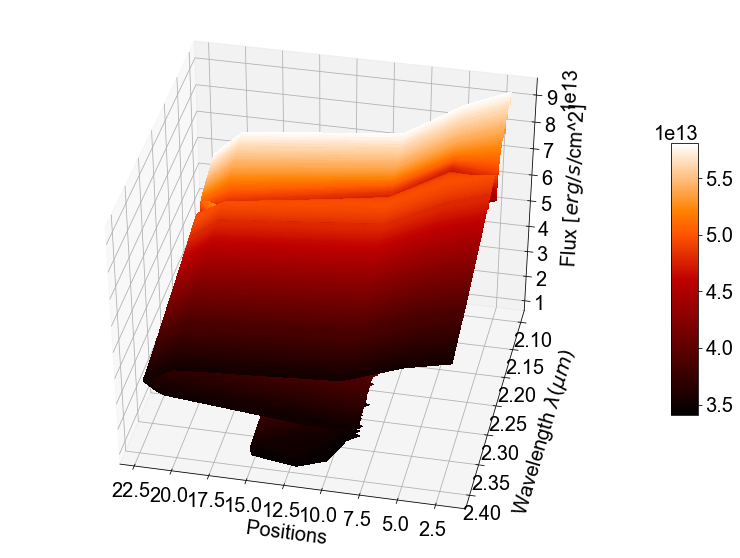

In [96]:
fig = plt.figure(figsize=(14,10))
ax = fig.gca(projection='3d')

# convert Angstrom to micrometer
waves_k_mu = []
[waves_k_mu.append(waves/10000) for waves in waves_k]
X, Y = np.meshgrid(pos, waves_k_mu)

surf = ax.plot_surface(X, Y, np.transpose(flux_k2D), rstride=20, cstride=40, cmap=cm.gist_heat, linewidth=1, antialiased=False)

# Add a color bar, axis properties
fig.colorbar(surf, shrink=0.5, aspect=10)
ax.set_xlabel('\n Positions' )
ax.set_ylabel('\n \n Wavelength'+ r'$\ \lambda (\mu m)$ ')
ax.set_zlabel('\n Flux'+r'$\ [erg/s/$cm^2$]$');
ax.view_init(40, 102)
plt.show()